In [6]:
import nbimporter # to import methods from another notebook
import manta_file_processing as mfp
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import time
import random
import os

In [7]:
heatmap_order=("left-eye","right-eye","left-gill","right-gill","tail")

In [8]:
from importlib import reload
reload(mfp)

Importing Jupyter notebook from manta_file_processing.ipynb


<module 'manta_file_processing' from 'manta_file_processing.ipynb'>

In [9]:
from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Dense,Conv2DTranspose
from tensorflow.python.keras.layers import BatchNormalization,AveragePooling2D,Activation
from tensorflow.python.keras.callbacks import EarlyStopping

from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.optimizers import Adam

In [10]:
filename="manta_index.csv"

if os.name=="nt":
    folder="C:\\YandexDisk\\_QUT\\Project_1\\MAntas_imag\\0_manta_selected_annotated_some"
else:
    folder="/tf/notebooks/data/0_manta_selected_annotated_some"
print("os = "+os.name)

if os.path.exists(filename):
    dataset=pd.read_csv(filename)
    print("loaded from ",filename)
else:
    print("folder: "+folder+"\n ---\ncollecting...")
    dataset=mfp.get_manta_files(folder=folder)
    dataset.to_csv(filename)

os = nt
loaded from  manta_index.csv


In [11]:
df=dataset[dataset.body_landmark_path.isnull()==False].sample(frac=1)
manta_data=np.array(df[["image_path","body_landmark_path"]])
#data=np.array([df.image_path,df.body_landmark_path])
manta_data.shape

(295, 2)

In [67]:
image_size=[100]*2
heatmap_size=[33]*2

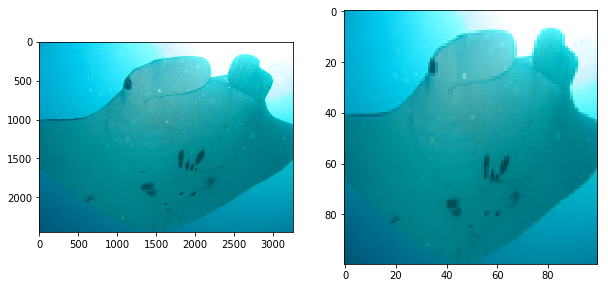

In [68]:
im_path,blm_path = manta_data[56]
image = Image.open(im_path)
body_landmarks=mfp.extract_body_landmarks(blm_path)
heatmaps=mfp.gen_heatmaps(body_landmarks,heatmap_size)

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 10))
axes[0].imshow(image)

image1=mfp.image_to_numpy(image,image_size)
axes[1].imshow(mfp.denormalize(image1))    
#axes[2].imshow(image[:,::-1])   
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


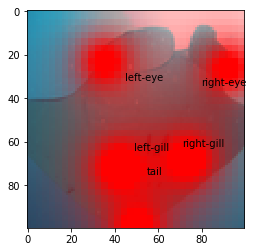

In [69]:
mfp.apply_heatmaps(mfp.denormalize(image1),heatmaps)

In [70]:
def flip_image(image):
    flip_image=image[::-1,:,]
    return flip_image

def flip_heatmaps(heatmaps):
    flip_heatmap=np.moveaxis(heatmaps[::-1,:,],-1,0)
    le,re,lg,rg,t=flip_heatmap
    flip_heatmap=np.array([re,le,rg,lg,t])
    flip_heatmap=np.moveaxis(flip_heatmap,0,-1)
    return flip_heatmap
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


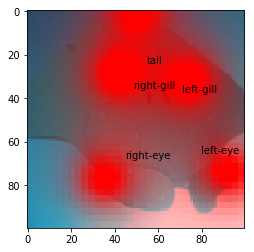

In [71]:
fi,fh=flip_image(mfp.denormalize(image1)),flip_heatmaps(heatmaps)
mfp.apply_heatmaps(fi,fh)

In [72]:
def load_Xy(manta_data,image_size,heatmap_size,model,rewrite=False,limit=0):
    X=[]
    y=[]
    F=[]

    #try to load data from existing files first
    features_filename = "features_"+model.name+str(image_size[0])+"x"+str(image_size[1])+".npy"
    heatmaps_filename="heatmaps"+str(heatmap_size[0])+"x"+str(heatmap_size[1])+".npy"
    
    print("trying to load fatures....")
    if os.path.exists(features_filename)==False or rewrite:
        print(features_filename, "is not exist. Will be generated.\n")
    else:
        print("loading from ",features_filename)
        F=np.load(features_filename)
        print("Successfully loaded\n")
        
    print("trying to load heatmaps....")
    if os.path.exists(heatmaps_filename)==False or rewrite:
        print(heatmaps_filename, "is not exist. Will be generated.\n")
    else:
        print("loading from ",heatmaps_filename)
        y=np.load(heatmaps_filename)
        print("Successfully loaded.\n")
        
    #loading and resizing images
    
    hm_needed=len(y)==0 or rewrite
    features_needed=len(F)==0 or rewrite
    
    i=0
    print("loading images...")
    print ("total:" + str(manta_data.shape[0]))
    
    if limit==0: limit=len(manta_data)
    for im_path,blm_path in manta_data[:limit]:
        try:
            image = Image.open(im_path)
            body_landmarks=mfp.extract_body_landmarks(blm_path)
        except:
            print(" \n Error on "+blm_path)

        image=mfp.image_to_numpy(image,image_size)
        if image.shape[2]>3:
            image=image[:,:,:3]
        if hm_needed:
            numpy_heatmaps=mfp.gen_heatmaps(body_landmarks,heatmap_size=heatmap_size)

        if body_landmarks is not None:
            if hm_needed:
                y.append(numpy_heatmaps)
                flip_hm=flip_heatmaps(numpy_heatmaps)
                y.append(flip_hm)
                
            X.append(image) 
            flip_img =flip_image(image)
            X.append(flip_img) 

        print(i,end=" ")
        i+=1    
        
    print('\n')
    X=np.array(X)
    if hm_needed:
        y=np.array(y)
        np.save(heatmaps_filename,y)
        print("\nHeatmaps updated and saved to", heatmaps_filename)
    
    if features_needed:
        print("Creating features...")
        F=model.predict(X)
        np.save(features_filename,F)
        print(" \nFeatures created and saved to ", features_filename)
    
    print("\n====================")
    print("Done.\nX.shape="+str(X.shape))
    print("y.shape="+str(y.shape))
    print("F.shape="+str(F.shape))
    

    
    return X,y,F

In [73]:
#pip install h5py
#pip install cython
#restart jupyther
import copy
input_shape=copy.copy(image_size)
input_shape.append(3)
vgg16_net = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape=input_shape)
vgg16_net.trainable = False

In [74]:
X,y,F=load_Xy(manta_data,image_size,heatmap_size,vgg16_net,rewrite=False)
#X,y,F=load_Xy(manta_data,image_size,heatmap_size,mymodel,rewrite=True)

trying to load fatures....
features_vgg16100x100.npy is not exist. Will be generated.

trying to load heatmaps....
heatmaps33x33.npy is not exist. Will be generated.

loading images...
total:295
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204  
 Error on C:\YandexDisk\_QUT\Project_1\MAntas_imag\0_manta_selected_annotated_some\0012 Laver

In [63]:
vgg16_net.name

'vgg16'

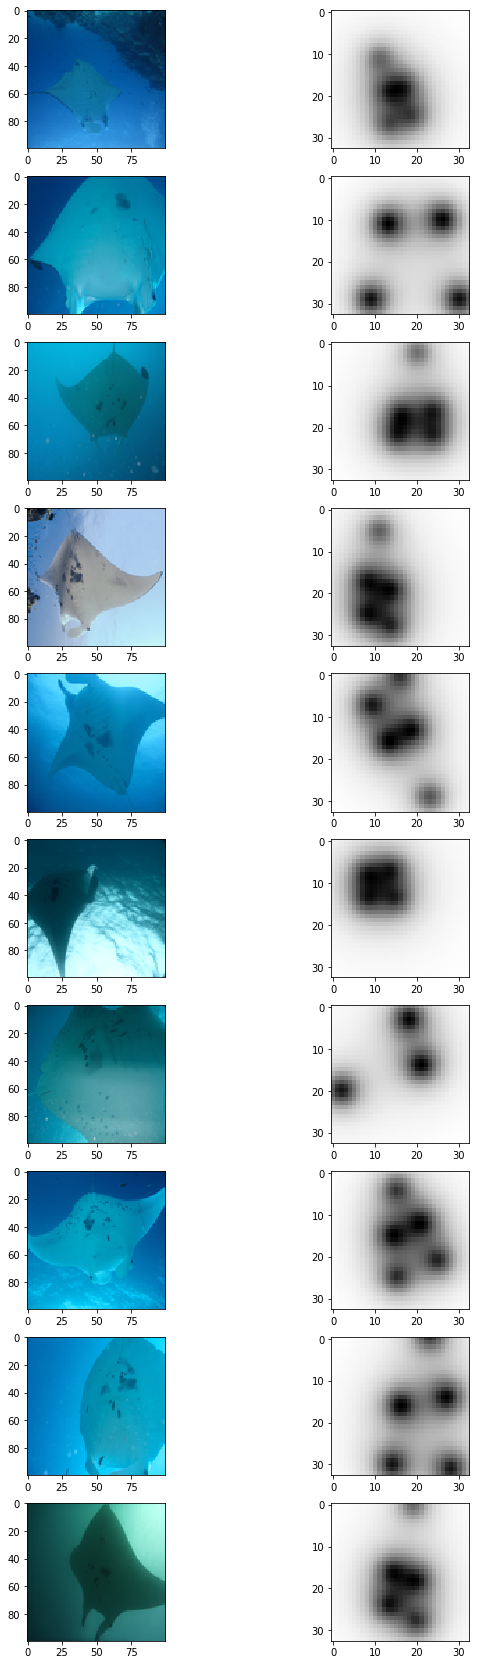

In [75]:
n=10
samples=random.sample(list(np.arange(X.shape[0])),n)
fig, axes = plt.subplots(nrows=n, ncols=2,figsize=(10, 30))
for i,s in zip(range(len(samples)),samples):
    axes[i,0].imshow(mfp.denormalize(X[s]))
    axes[i,1].imshow(y[s].sum(axis=2),cmap='Greys')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


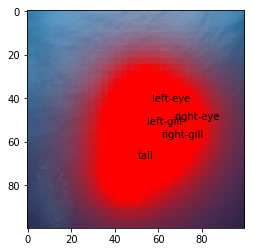

In [76]:
i=18
mfp.apply_heatmaps(mfp.denormalize(X[i]),y[i])
    

In [77]:
batch_size=32
nb_train_samples=int(round(X.shape[0]*0.95,0))
pics_train =X[:nb_train_samples]
pics_test=X[nb_train_samples:]

X_train=F[:nb_train_samples]
X_test =F[nb_train_samples:]

y_train=y[:nb_train_samples]
y_test =y[nb_train_samples:]

In [78]:
from tensorflow.keras.models import Model

mymodel = Model(vgg16_net.get_input_at(0), vgg16_net.layers[17].get_output_at(0))
mymodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [79]:
model=Sequential()
#model.add(vgg16_net)
#model.add(mymodel)

#input_shape=mymodel.layers[-1].output_shape[1:]
input_shape=vgg16_net.layers[-1].output_shape[1:]

model.add(BatchNormalization(input_shape=input_shape))



model.add(Conv2DTranspose(filters=256,
                         kernel_size=3,
                         strides=2, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=64,
                         kernel_size=3,
                         strides=2, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=32,
                         kernel_size=3,
                         strides=2, 
                         activation='relu'))
model.add(BatchNormalization())
'''
model.add(Conv2DTranspose(filters=32,
                         kernel_size=3,
                         strides=2, 
                         activation='relu'))
model.add(BatchNormalization())
'''
model.add(Conv2DTranspose(filters=5,
                         kernel_size=3,
                         strides=1, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Activation('sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_30 (Batc (None, 3, 3, 512)         2048      
_________________________________________________________________
conv2d_transpose_24 (Conv2DT (None, 7, 7, 256)         1179904   
_________________________________________________________________
batch_normalization_31 (Batc (None, 7, 7, 256)         1024      
_________________________________________________________________
conv2d_transpose_25 (Conv2DT (None, 15, 15, 64)        147520    
_________________________________________________________________
batch_normalization_32 (Batc (None, 15, 15, 64)        256       
_________________________________________________________________
conv2d_transpose_26 (Conv2DT (None, 31, 31, 32)        18464     
_________________________________________________________________
batch_normalization_33 (Batc (None, 31, 31, 32)        128       
__________

In [80]:
model.compile(loss='binary_crossentropy',
optimizer='adam',
metrics=['binary_accuracy'])

In [81]:
start_time = time.time()
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=30)

history=model.fit(X_train,y_train,batch_size=batch_size,epochs=600,validation_split=0.1,callbacks=[early_stopping_callback])

training_time=round(time.time() - start_time,2)

Train on 504 samples, validate on 56 samples
Epoch 1/600
504/504 [==============================] - 6s 11ms/step - loss: 0.7233 - binary_accuracy: 0.0462 - val_loss: 1.5273 - val_binary_accuracy: 0.0351
Epoch 2/600
504/504 [==============================] - 2s 3ms/step - loss: 0.6946 - binary_accuracy: 0.0493 - val_loss: 0.9315 - val_binary_accuracy: 0.0481
Epoch 3/600
504/504 [==============================] - 2s 3ms/step - loss: 0.6809 - binary_accuracy: 0.0488 - val_loss: 0.6926 - val_binary_accuracy: 0.0549
Epoch 4/600
504/504 [==============================] - 2s 3ms/step - loss: 0.6657 - binary_accuracy: 0.0495 - val_loss: 0.6559 - val_binary_accuracy: 0.0544
Epoch 5/600
504/504 [==============================] - 2s 3ms/step - loss: 0.6513 - binary_accuracy: 0.0501 - val_loss: 0.6431 - val_binary_accuracy: 0.0543
Epoch 6/600
504/504 [==============================] - 2s 3ms/step - loss: 0.6382 - binary_accuracy: 0.0508 - val_loss: 0.6364 - val_binary_accuracy: 0.0528
Epoch 7/600


Epoch 104/600
504/504 [==============================] - 2s 3ms/step - loss: 0.3404 - binary_accuracy: 0.0532 - val_loss: 0.3784 - val_binary_accuracy: 0.0569
Epoch 105/600
504/504 [==============================] - 2s 4ms/step - loss: 0.3395 - binary_accuracy: 0.0532 - val_loss: 0.3780 - val_binary_accuracy: 0.0568
Epoch 106/600
504/504 [==============================] - 2s 4ms/step - loss: 0.3386 - binary_accuracy: 0.0532 - val_loss: 0.3767 - val_binary_accuracy: 0.0567
Epoch 107/600
504/504 [==============================] - 2s 4ms/step - loss: 0.3376 - binary_accuracy: 0.0532 - val_loss: 0.3755 - val_binary_accuracy: 0.0569
Epoch 108/600
504/504 [==============================] - 2s 4ms/step - loss: 0.3367 - binary_accuracy: 0.0532 - val_loss: 0.3748 - val_binary_accuracy: 0.0569
Epoch 109/600
504/504 [==============================] - 2s 4ms/step - loss: 0.3359 - binary_accuracy: 0.0532 - val_loss: 0.3748 - val_binary_accuracy: 0.0568
Epoch 110/600
504/504 [=======================

504/504 [==============================] - 2s 4ms/step - loss: 0.2974 - binary_accuracy: 0.0532 - val_loss: 0.3492 - val_binary_accuracy: 0.0572
Epoch 207/600
504/504 [==============================] - 2s 4ms/step - loss: 0.2973 - binary_accuracy: 0.0532 - val_loss: 0.3492 - val_binary_accuracy: 0.0572
Epoch 208/600
504/504 [==============================] - 2s 4ms/step - loss: 0.2971 - binary_accuracy: 0.0532 - val_loss: 0.3494 - val_binary_accuracy: 0.0572
Epoch 209/600
504/504 [==============================] - 2s 4ms/step - loss: 0.2970 - binary_accuracy: 0.0532 - val_loss: 0.3491 - val_binary_accuracy: 0.0572
Epoch 210/600
504/504 [==============================] - 2s 3ms/step - loss: 0.2967 - binary_accuracy: 0.0532 - val_loss: 0.3486 - val_binary_accuracy: 0.0572
Epoch 211/600
504/504 [==============================] - 2s 3ms/step - loss: 0.2966 - binary_accuracy: 0.0532 - val_loss: 0.3493 - val_binary_accuracy: 0.0572
Epoch 212/600
504/504 [==============================] - 2s 


Training time :'--- 8.0 min 6.970000000000027 sec ---


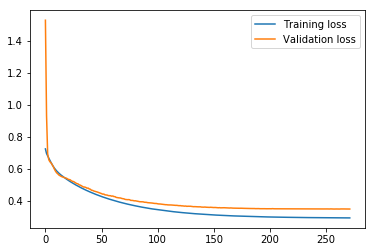

In [82]:
print("\nTraining time :'--- %s min %s sec ---" % (training_time//60,training_time%60) )
loss = history.history['loss']
val_loss= history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['Training loss','Validation loss'])
plt.show()

In [83]:
pred=model.predict(X_test)
print(X_test.shape)
print(pred.shape)

(30, 3, 3, 512)
(30, 33, 33, 5)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


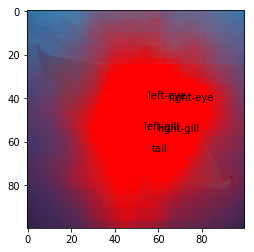

In [90]:
i=14
mfp.apply_heatmaps(mfp.denormalize(pics_test[i]),pred[i])

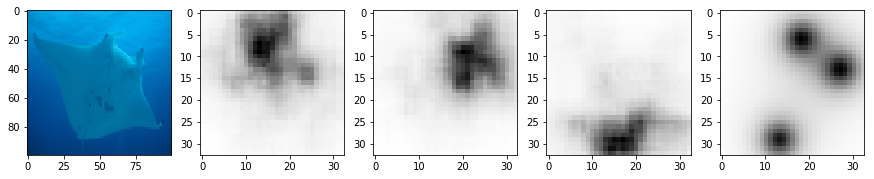

In [91]:
fig, axes = plt.subplots(nrows=1, ncols=5,figsize=(15, 30))
axes[0].imshow(mfp.denormalize(pics_test[i]))
axes[1].imshow(pred[i][:,:,0],cmap='Greys')
axes[2].imshow(pred[i][:,:,1],cmap='Greys')
#axes[i,3].imshow(pred[s][:,:,2],cmap='Greys')
axes[3].imshow(pred[i][:,:,4],cmap='Greys')
axes[4].imshow(y_test[i][:,:,[0,1,4]].sum(axis=2),cmap='Greys')

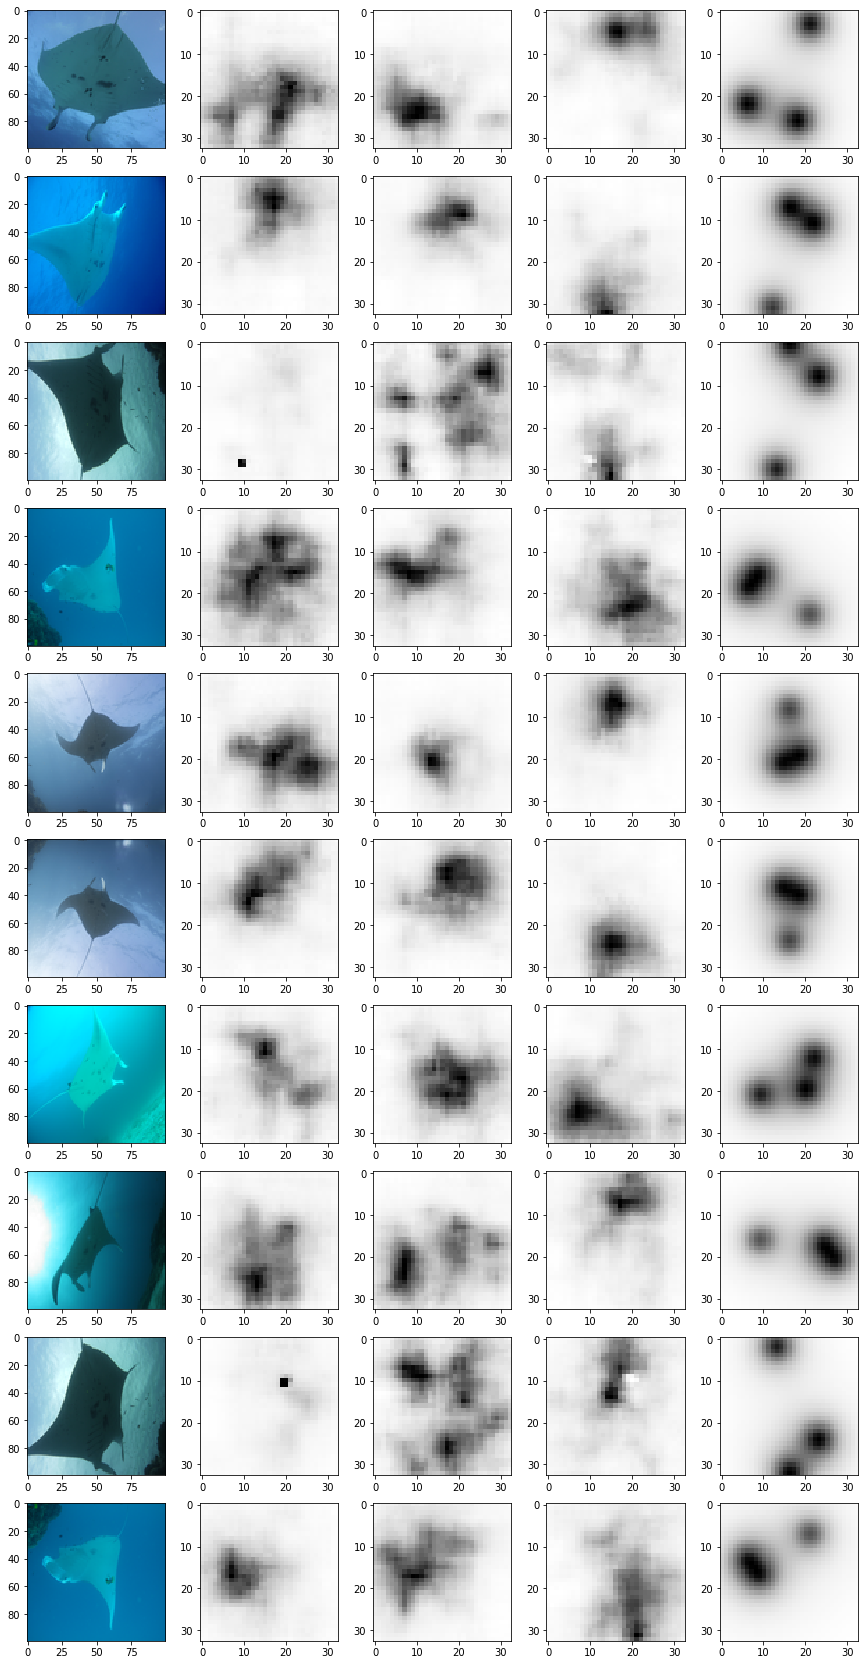

In [87]:
n=10#X_test.shape[0]
samples=random.sample(list(np.arange(pred.shape[0])),n)
fig, axes = plt.subplots(nrows=n, ncols=5,figsize=(15, 30))
for i,s in zip(range(len(samples)),samples):
    axes[i,0].imshow(mfp.denormalize(pics_test[s]))
    axes[i,1].imshow(pred[s][:,:,0],cmap='Greys')
    axes[i,2].imshow(pred[s][:,:,1],cmap='Greys')
    #axes[i,3].imshow(pred[s][:,:,2],cmap='Greys')
    axes[i,3].imshow(pred[s][:,:,4],cmap='Greys')
    axes[i,4].imshow(y_test[s][:,:,[0,1,4]].sum(axis=2),cmap='Greys')
plt.show()